In [31]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import os
from keras.models import load_model
from art.attacks.extraction import CopycatCNN
import numpy as np

In [32]:
# Cargar el modelo guardado
model = load_model("malwareImg")

# Cargar los datos de entrenamiento y prueba
train_images = np.load('Imagetrain.npy')
train_labels = np.load('Imagetext.npy')
test_images = np.load('Imagetest.npy')  # Modificado para usar np.load
test_labels = np.loadtxt('ImagetextTest')

In [33]:
# Normalizar los datos de imagen
train_images = train_images / 255.0
test_images = test_images / 255.0

# Importar el wrapper del modelo para ART
from art.estimators.classification import KerasClassifier

In [34]:
# Crear el objeto del modelo para ART
classifier = KerasClassifier(model=model, clip_values=(0, 1))

# Definir el ataque de extracción
attack = CopycatCNN(classifier=classifier, batch_size_fit=128, batch_size_query=128, nb_epochs=10, nb_stolen=1000)

In [39]:
layers = tf.keras.layers
models = tf.keras.models

data_path = 'malimg_dataset/malimg_paper_dataset_imgs/'
families = os.listdir(data_path)

# Crear una nueva instancia del modelo con la misma arquitectura
thieved_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(families), activation='softmax')
])

# Compilando el modelo
thieved_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [40]:
# Crear el objeto de ART para el modelo vacío
thieved_classifier = KerasClassifier(model=thieved_model, clip_values=(0, 1))

# Crear un modelo robado
stolen_classifier = attack.extract(x=train_images, thieved_classifier=thieved_classifier)

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 5s 5ms/sample - loss: 2.2737 - accuracy: 0.3490
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.5230 - accuracy: 0.4720
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.3548 - accuracy: 0.4830
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.1659 - accuracy: 0.4840
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.9485 - accuracy: 0.6110
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.8049 - accuracy: 0.6720
Epoch 7/10
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.6558 - accuracy: 0.7050
Epoch 8/10
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.5664 - accuracy: 0.7100
Epoch 9/10
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.5020 - accuracy: 0.7540
Epoch 10/10
1000/1000 [===================

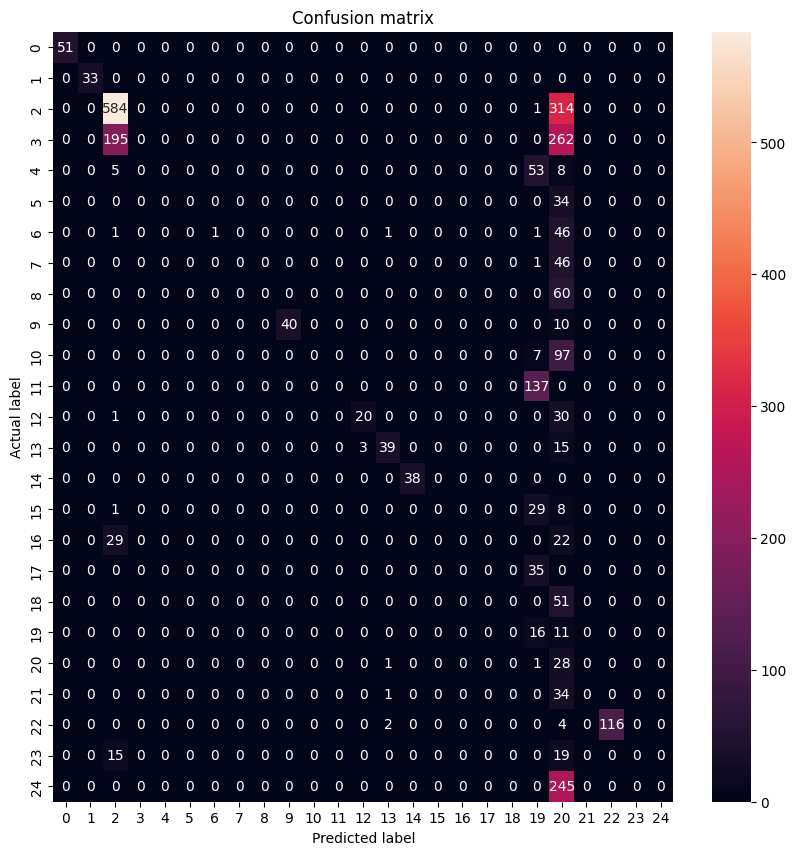

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluar el rendimiento del modelo robado
stolen_preds = stolen_classifier.predict(x=test_images)

# Convertir las predicciones de probabilidad a clases
stolen_preds_classes = np.argmax(stolen_preds, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(test_labels, stolen_preds_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


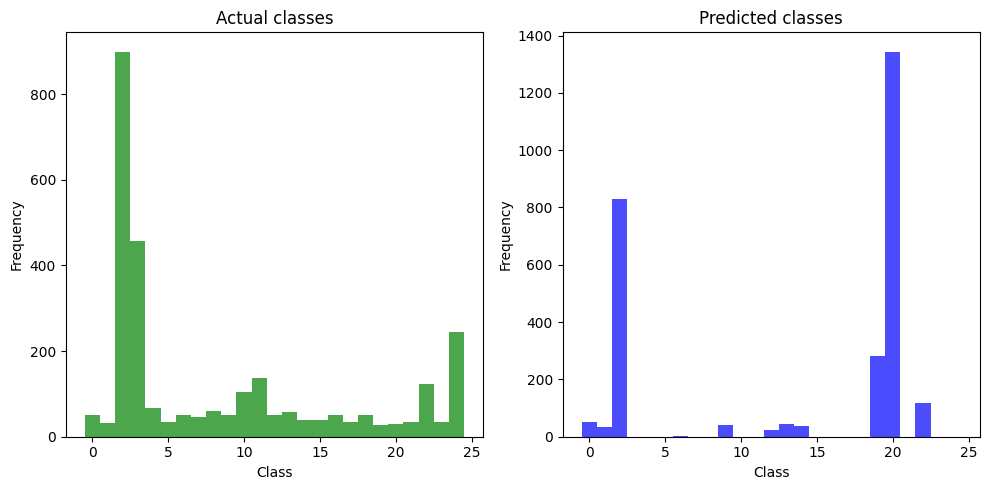

In [44]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(test_labels, bins=range(len(families)+1), alpha=0.7, color='g', align='left')
plt.title('Actual classes')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(stolen_preds_classes, bins=range(len(families)+1), alpha=0.7, color='b', align='left')
plt.title('Predicted classes')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Algunas clases son predichas con gran precisión, estas son las clases 1, 2, 10, 15, 24, entre otras, tienen la mayoría de sus predicciones correctas, ya que los valores en la diagonal son altos y hay pocos o ningún error de clasificación en otras celdas de la misma fila.

 Las clases 3 y 4 tienen una gran cantidad de errores de clasificación. Parece que el modelo confunde frecuentemente estas clases con las clases 21 y 22 respectivamente. Esto podría sugerir que estas clases son similares en alguna manera que confunde al modelo, o que el modelo necesita más datos de entrenamiento para estas clases para aprender a distinguirlas mejor.